# tile llc model run and distribute parcels runs


Messages/Questions pour Sylvie:

- `parcels.py` - Pourquoi les tiles 23 et 3 et le drifter 3000002.0 sont-ils traités de manière particulière?
- ajout de particules au fil des simulations, comment
- dans la boucle de run: pourquoi les steps supérieurs à 1000 sont ils considérés différemment?
- pourquoi les numéros de trajectoire ne sont pas entier?
- peut-on directement sortir les vitesses?
- peut-on ajouter la profondeur?
- ligne 683, 733: `del pset` ne sert à rien je pense, à vérifier

- l'arborescence a changé: `/run`, `/tiling`, `/parquets`, `/diagnostics`

- [ ] try to change time stepping scheme: RK4


In [1]:
import os, shutil

import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
import geopandas

import dask
from dask.delayed import delayed

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster

# ** processes and cores may be adjusted in order to have more memory or inversely more 
# ** computational ressource

cluster = PBSCluster(processes=5, cores=5, walltime='48:00:00')
#cluster = PBSCluster(walltime='04:00:00')
w = cluster.scale(jobs=5)

#cluster = PBSCluster()

client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.22:57525 Dashboard: http://10.148.0.22:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## setup directories and run parameters

In [3]:
root_dir = '/home1/scratch/aponte/parcels/'
#root_dir = '/home1/datawork/slgentil/parcels/'

# 5x5 tiles dij=100 T=365 5jobs x 5workers
run_name = 'global_T365j_dt1j_dij50'

overwrite = False

In [4]:
# simulation parameters

#T = 360? # length of the total run [days]
T = 20 # ** debug
#dt_windows = 5 # time window
dt_windows = 2 # ** debug, 5j devrait être plus approprié je pense
dt_stepping = 1 # hours
dt_outputs = 1 # hours

dij_init = 10 # initial position subsampling compared to llc grid

In [ ]:
# create and/or overwrite run_dir
run_dir = root_dir+run_name
if overwrite:
    shutil.rmtree(run_dir, ignore_errors=True)
if not os.path.isdir(run_dir):
        os.mkdir(run_dir)

---

## load llc data

In [5]:
# load llc data
ds = ut.load_data(V=['SST', 'SSU', 'SSV'])
grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
ds = xr.merge([ds, grd])
ds

CPU times: user 1.58 s, sys: 132 ms, total: 1.72 s
Wall time: 32.6 s


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 8785)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxC      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSU      (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSV      (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

---

## create tiles

This could be done somewhere else, in another notebook

See `rearrange.ipynb` and `tile.ipynb` for more details

** Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant

In [6]:
create_tiles = True
tile_dir = os.path.join(run_dir,'tiling/')

if create_tiles:
    
    # ** could filter out tiles that are empty, criterium on Depth or SST should be sufficient
    # create tiler
    #tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 5), overlap=(100, 100))
    #tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 5), overlap=(200, 200))
    tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 5), overlap=(250, 250))
    # store tiler
    tl.store(tile_dir)
    
else:
    tl = pa.tiler(tile_dir=tile_dir)
    
tile_data_dirs = [os.path.join(run_dir,'data_{:03d}'.format(t)) 
                  for t in range(tl.N_tiles)
                 ]

Create new diagnostic directory /home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/tiling/
Tiler stored in /home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/tiling/
CPU times: user 9.35 s, sys: 408 ms, total: 9.76 s
Wall time: 1min 15s


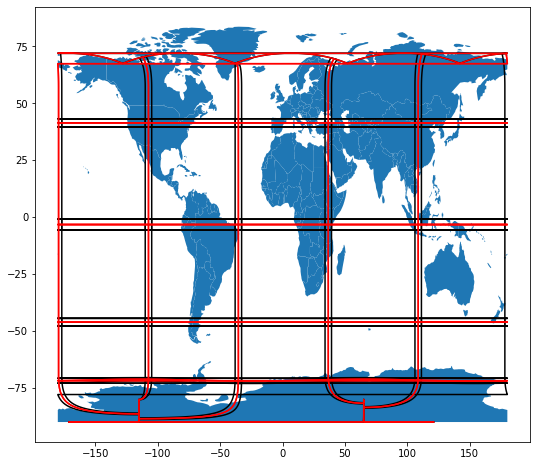

CPU times: user 7.58 s, sys: 9.76 s, total: 17.3 s
Wall time: 6.92 s


In [7]:
crs = tl.crs_wgs84

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
new_world = world.to_crs(crs)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
new_world.plot(ax=ax)
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color="black")
for b in tl.G['boundaries']:
    b.to_crs(crs).boundary.plot(ax=ax, color="red")
#ax.set_axis_off()
plt.show()

In [8]:
# create a tree of directories to store data
for t in tile_data_dirs:
    if os.path.isdir(t):
        pass
    else:
        os.mkdir(t)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 38.5 ms


--- 

## loop over time windows (main loop)

** we will probably need a restart mechanism the loop from a given time, it may be as simple as changing `np.arange(0,T, dt_windows)` into `np.arange(t_restart,T, dt_windows)`

** we may need to manually clear memory (for example if llc dataset has been persisted within tile_store_llc)


In [ ]:
%%time

tbegin = ut.np64toDate(ds['time'][0].values)
dt_windows = timedelta(days=1.)
#tend = tbegin + 10*dt_windows
tend = tbegin + 365*dt_windows
dt_outputs = timedelta(hours=1.)
dt_step = timedelta(hours=1.)
dij = 50

print('begin =',tbegin.strftime("%Y-%m-%d:%H"))
print('end=',tend.strftime("%Y-%m-%d:%H"))  

#for step, t in enumerate(np.arange(t_restart, T, dt_windows)):
for step, t in enumerate(ut.dateRange(tbegin, tend, dt_windows)):
     
    endtime = t+dt_windows+dt_step
    print('-------------------------------------------')
    print('step=',step)
    print('start=',t.strftime("%Y-%m-%d:%H"))
    print('end=',endtime.strftime("%Y-%m-%d:%H")) 
    # load, tile and store llc data
    ds_tiles = pa.tile_store_llc(ds,
                  #slice(t*day2hour, (t+dt_windows)*day2hour, None),
                  slice(t, endtime, None),
                  tl,
                  tile_data_dirs,
                  netcdf=False)
    
    if step > 1000 :
        # looks like a hack to run without dask: sylvie confirms?
        for tile in range(tl.N_tiles):
            pa.step_window(tile, step, t, endtime, dt_windows, tl, run_dir,
                                      ds_tile=ds_tiles[tile], init_dij=dij, 
                                      parcels_remove_on_land=True,
                                     ) 
    else:
        dsteps = [delayed(pa.step_window)(tile, step, t, endtime, dt_windows, 
                                          tl, run_dir,
                                          ds_tile=ds_tiles[tile], init_dij=dij, 
                                          parcels_remove_on_land=True,
                                         ) 
                  for tile in range(tl.N_tiles)
                 ]
        dsteps_out = dask.compute(*dsteps) 

        del dsteps
        del dsteps_out
        del ds_tiles

begin = 2011-11-15:00
end= 2012-11-14:00
-------------------------------------------
step= 0
start= 2011-11-15:00
end= 2011-11-16:01


100%|██████████| 25/25 [00:00<00:00, 542.29it/s]


-------------------------------------------
step= 1
start= 2011-11-16:00
end= 2011-11-17:01


100%|██████████| 25/25 [00:00<00:00, 534.99it/s]


-------------------------------------------
step= 2
start= 2011-11-17:00
end= 2011-11-18:01


100%|██████████| 25/25 [00:00<00:00, 533.95it/s]


-------------------------------------------
step= 3
start= 2011-11-18:00
end= 2011-11-19:01


100%|██████████| 25/25 [00:00<00:00, 533.55it/s]


-------------------------------------------
step= 4
start= 2011-11-19:00
end= 2011-11-20:01


100%|██████████| 25/25 [00:00<00:00, 518.16it/s]


-------------------------------------------
step= 5
start= 2011-11-20:00
end= 2011-11-21:01


100%|██████████| 25/25 [00:00<00:00, 502.87it/s]


-------------------------------------------
step= 6
start= 2011-11-21:00
end= 2011-11-22:01


100%|██████████| 25/25 [00:00<00:00, 534.51it/s]


-------------------------------------------
step= 7
start= 2011-11-22:00
end= 2011-11-23:01


100%|██████████| 25/25 [00:00<00:00, 540.53it/s]


-------------------------------------------
step= 8
start= 2011-11-23:00
end= 2011-11-24:01


100%|██████████| 25/25 [00:00<00:00, 536.14it/s]


-------------------------------------------
step= 9
start= 2011-11-24:00
end= 2011-11-25:01


100%|██████████| 25/25 [00:00<00:00, 540.43it/s]


-------------------------------------------
step= 10
start= 2011-11-25:00
end= 2011-11-26:01


100%|██████████| 25/25 [00:00<00:00, 530.77it/s]


-------------------------------------------
step= 11
start= 2011-11-26:00
end= 2011-11-27:01


100%|██████████| 25/25 [00:00<00:00, 545.26it/s]


-------------------------------------------
step= 12
start= 2011-11-27:00
end= 2011-11-28:01


100%|██████████| 25/25 [00:00<00:00, 532.69it/s]


-------------------------------------------
step= 13
start= 2011-11-28:00
end= 2011-11-29:01


100%|██████████| 25/25 [00:00<00:00, 533.79it/s]


-------------------------------------------
step= 14
start= 2011-11-29:00
end= 2011-11-30:01


100%|██████████| 25/25 [00:00<00:00, 516.01it/s]


-------------------------------------------
step= 15
start= 2011-11-30:00
end= 2011-12-01:01


100%|██████████| 25/25 [00:00<00:00, 512.02it/s]


-------------------------------------------
step= 16
start= 2011-12-01:00
end= 2011-12-02:01


100%|██████████| 25/25 [00:00<00:00, 530.55it/s]


-------------------------------------------
step= 17
start= 2011-12-02:00
end= 2011-12-03:01


100%|██████████| 25/25 [00:00<00:00, 529.81it/s]


-------------------------------------------
step= 18
start= 2011-12-03:00
end= 2011-12-04:01


100%|██████████| 25/25 [00:00<00:00, 547.99it/s]


-------------------------------------------
step= 19
start= 2011-12-04:00
end= 2011-12-05:01


100%|██████████| 25/25 [00:00<00:00, 533.66it/s]


-------------------------------------------
step= 20
start= 2011-12-05:00
end= 2011-12-06:01


100%|██████████| 25/25 [00:00<00:00, 534.03it/s]


-------------------------------------------
step= 21
start= 2011-12-06:00
end= 2011-12-07:01


100%|██████████| 25/25 [00:00<00:00, 515.28it/s]


-------------------------------------------
step= 22
start= 2011-12-07:00
end= 2011-12-08:01


100%|██████████| 25/25 [00:00<00:00, 510.96it/s]


-------------------------------------------
step= 23
start= 2011-12-08:00
end= 2011-12-09:01


100%|██████████| 25/25 [00:00<00:00, 542.42it/s]


-------------------------------------------
step= 24
start= 2011-12-09:00
end= 2011-12-10:01


100%|██████████| 25/25 [00:00<00:00, 531.05it/s]


-------------------------------------------
step= 25
start= 2011-12-10:00
end= 2011-12-11:01


100%|██████████| 25/25 [00:00<00:00, 514.40it/s]


-------------------------------------------
step= 26
start= 2011-12-11:00
end= 2011-12-12:01


100%|██████████| 25/25 [00:00<00:00, 454.45it/s]


-------------------------------------------
step= 27
start= 2011-12-12:00
end= 2011-12-13:01


100%|██████████| 25/25 [00:00<00:00, 504.22it/s]


-------------------------------------------
step= 28
start= 2011-12-13:00
end= 2011-12-14:01


100%|██████████| 25/25 [00:00<00:00, 446.34it/s]


-------------------------------------------
step= 29
start= 2011-12-14:00
end= 2011-12-15:01


100%|██████████| 25/25 [00:00<00:00, 489.34it/s]


-------------------------------------------
step= 30
start= 2011-12-15:00
end= 2011-12-16:01


100%|██████████| 25/25 [00:00<00:00, 520.95it/s]


-------------------------------------------
step= 31
start= 2011-12-16:00
end= 2011-12-17:01


100%|██████████| 25/25 [00:00<00:00, 503.27it/s]


-------------------------------------------
step= 32
start= 2011-12-17:00
end= 2011-12-18:01


100%|██████████| 25/25 [00:00<00:00, 480.19it/s]


-------------------------------------------
step= 33
start= 2011-12-18:00
end= 2011-12-19:01


100%|██████████| 25/25 [00:00<00:00, 522.89it/s]


-------------------------------------------
step= 34
start= 2011-12-19:00
end= 2011-12-20:01


100%|██████████| 25/25 [00:00<00:00, 477.35it/s]


-------------------------------------------
step= 35
start= 2011-12-20:00
end= 2011-12-21:01


100%|██████████| 25/25 [00:00<00:00, 532.48it/s]


-------------------------------------------
step= 36
start= 2011-12-21:00
end= 2011-12-22:01


100%|██████████| 25/25 [00:00<00:00, 496.22it/s]


-------------------------------------------
step= 37
start= 2011-12-22:00
end= 2011-12-23:01


100%|██████████| 25/25 [00:00<00:00, 532.76it/s]


-------------------------------------------
step= 38
start= 2011-12-23:00
end= 2011-12-24:01


100%|██████████| 25/25 [00:00<00:00, 466.30it/s]


-------------------------------------------
step= 39
start= 2011-12-24:00
end= 2011-12-25:01


100%|██████████| 25/25 [00:00<00:00, 513.00it/s]


-------------------------------------------
step= 40
start= 2011-12-25:00
end= 2011-12-26:01


100%|██████████| 25/25 [00:00<00:00, 535.87it/s]


-------------------------------------------
step= 41
start= 2011-12-26:00
end= 2011-12-27:01


100%|██████████| 25/25 [00:00<00:00, 473.97it/s]


-------------------------------------------
step= 42
start= 2011-12-27:00
end= 2011-12-28:01


100%|██████████| 25/25 [00:00<00:00, 471.53it/s]


-------------------------------------------
step= 43
start= 2011-12-28:00
end= 2011-12-29:01


100%|██████████| 25/25 [00:00<00:00, 496.06it/s]


-------------------------------------------
step= 44
start= 2011-12-29:00
end= 2011-12-30:01


100%|██████████| 25/25 [00:00<00:00, 538.72it/s]


-------------------------------------------
step= 45
start= 2011-12-30:00
end= 2011-12-31:01


100%|██████████| 25/25 [00:00<00:00, 514.29it/s]


-------------------------------------------
step= 46
start= 2011-12-31:00
end= 2012-01-01:01


100%|██████████| 25/25 [00:00<00:00, 545.83it/s]


-------------------------------------------
step= 47
start= 2012-01-01:00
end= 2012-01-02:01


100%|██████████| 25/25 [00:00<00:00, 545.23it/s]


-------------------------------------------
step= 48
start= 2012-01-02:00
end= 2012-01-03:01


100%|██████████| 25/25 [00:00<00:00, 519.35it/s]


-------------------------------------------
step= 49
start= 2012-01-03:00
end= 2012-01-04:01


100%|██████████| 25/25 [00:00<00:00, 535.80it/s]


-------------------------------------------
step= 50
start= 2012-01-04:00
end= 2012-01-05:01


100%|██████████| 25/25 [00:00<00:00, 529.16it/s]


-------------------------------------------
step= 51
start= 2012-01-05:00
end= 2012-01-06:01


100%|██████████| 25/25 [00:00<00:00, 485.84it/s]


-------------------------------------------
step= 52
start= 2012-01-06:00
end= 2012-01-07:01


100%|██████████| 25/25 [00:00<00:00, 526.37it/s]


-------------------------------------------
step= 53
start= 2012-01-07:00
end= 2012-01-08:01


100%|██████████| 25/25 [00:00<00:00, 508.14it/s]


-------------------------------------------
step= 54
start= 2012-01-08:00
end= 2012-01-09:01


100%|██████████| 25/25 [00:00<00:00, 534.91it/s]


-------------------------------------------
step= 55
start= 2012-01-09:00
end= 2012-01-10:01


100%|██████████| 25/25 [00:00<00:00, 494.36it/s]


-------------------------------------------
step= 56
start= 2012-01-10:00
end= 2012-01-11:01


100%|██████████| 25/25 [00:00<00:00, 541.70it/s]


-------------------------------------------
step= 57
start= 2012-01-11:00
end= 2012-01-12:01


100%|██████████| 25/25 [00:00<00:00, 503.39it/s]


-------------------------------------------
step= 58
start= 2012-01-12:00
end= 2012-01-13:01


100%|██████████| 25/25 [00:00<00:00, 529.30it/s]


-------------------------------------------
step= 59
start= 2012-01-13:00
end= 2012-01-14:01


100%|██████████| 25/25 [00:00<00:00, 546.76it/s]


-------------------------------------------
step= 60
start= 2012-01-14:00
end= 2012-01-15:01


100%|██████████| 25/25 [00:00<00:00, 498.84it/s]


-------------------------------------------
step= 61
start= 2012-01-15:00
end= 2012-01-16:01


100%|██████████| 25/25 [00:00<00:00, 529.97it/s]


-------------------------------------------
step= 62
start= 2012-01-16:00
end= 2012-01-17:01


100%|██████████| 25/25 [00:00<00:00, 530.35it/s]


-------------------------------------------
step= 63
start= 2012-01-17:00
end= 2012-01-18:01


100%|██████████| 25/25 [00:00<00:00, 496.22it/s]


-------------------------------------------
step= 64
start= 2012-01-18:00
end= 2012-01-19:01


100%|██████████| 25/25 [00:00<00:00, 525.66it/s]


-------------------------------------------
step= 65
start= 2012-01-19:00
end= 2012-01-20:01


100%|██████████| 25/25 [00:00<00:00, 517.41it/s]


-------------------------------------------
step= 66
start= 2012-01-20:00
end= 2012-01-21:01


100%|██████████| 25/25 [00:00<00:00, 528.76it/s]


-------------------------------------------
step= 67
start= 2012-01-21:00
end= 2012-01-22:01


100%|██████████| 25/25 [00:00<00:00, 483.25it/s]


-------------------------------------------
step= 68
start= 2012-01-22:00
end= 2012-01-23:01


100%|██████████| 25/25 [00:00<00:00, 517.79it/s]


-------------------------------------------
step= 69
start= 2012-01-23:00
end= 2012-01-24:01


100%|██████████| 25/25 [00:00<00:00, 523.58it/s]


-------------------------------------------
step= 70
start= 2012-01-24:00
end= 2012-01-25:01


100%|██████████| 25/25 [00:00<00:00, 514.27it/s]


-------------------------------------------
step= 71
start= 2012-01-25:00
end= 2012-01-26:01


100%|██████████| 25/25 [00:00<00:00, 516.80it/s]


-------------------------------------------
step= 72
start= 2012-01-26:00
end= 2012-01-27:01


100%|██████████| 25/25 [00:00<00:00, 501.32it/s]


-------------------------------------------
step= 73
start= 2012-01-27:00
end= 2012-01-28:01


100%|██████████| 25/25 [00:00<00:00, 535.09it/s]


-------------------------------------------
step= 74
start= 2012-01-28:00
end= 2012-01-29:01


100%|██████████| 25/25 [00:00<00:00, 493.28it/s]


-------------------------------------------
step= 75
start= 2012-01-29:00
end= 2012-01-30:01


100%|██████████| 25/25 [00:00<00:00, 470.17it/s]


-------------------------------------------
step= 76
start= 2012-01-30:00
end= 2012-01-31:01


100%|██████████| 25/25 [00:00<00:00, 522.48it/s]


-------------------------------------------
step= 77
start= 2012-01-31:00
end= 2012-02-01:01


100%|██████████| 25/25 [00:00<00:00, 481.40it/s]


-------------------------------------------
step= 78
start= 2012-02-01:00
end= 2012-02-02:01


100%|██████████| 25/25 [00:00<00:00, 538.15it/s]


-------------------------------------------
step= 79
start= 2012-02-02:00
end= 2012-02-03:01


100%|██████████| 25/25 [00:00<00:00, 502.20it/s]


-------------------------------------------
step= 80
start= 2012-02-03:00
end= 2012-02-04:01


100%|██████████| 25/25 [00:00<00:00, 503.41it/s]


-------------------------------------------
step= 81
start= 2012-02-04:00
end= 2012-02-05:01


100%|██████████| 25/25 [00:00<00:00, 503.35it/s]


-------------------------------------------
step= 82
start= 2012-02-05:00
end= 2012-02-06:01


100%|██████████| 25/25 [00:00<00:00, 536.49it/s]


-------------------------------------------
step= 83
start= 2012-02-06:00
end= 2012-02-07:01


100%|██████████| 25/25 [00:00<00:00, 515.40it/s]


-------------------------------------------
step= 84
start= 2012-02-07:00
end= 2012-02-08:01


100%|██████████| 25/25 [00:00<00:00, 468.09it/s]


-------------------------------------------
step= 85
start= 2012-02-08:00
end= 2012-02-09:01


100%|██████████| 25/25 [00:00<00:00, 539.45it/s]


-------------------------------------------
step= 86
start= 2012-02-09:00
end= 2012-02-10:01


100%|██████████| 25/25 [00:00<00:00, 508.28it/s]


-------------------------------------------
step= 87
start= 2012-02-10:00
end= 2012-02-11:01


100%|██████████| 25/25 [00:00<00:00, 501.10it/s]


-------------------------------------------
step= 88
start= 2012-02-11:00
end= 2012-02-12:01


100%|██████████| 25/25 [00:00<00:00, 517.54it/s]


-------------------------------------------
step= 89
start= 2012-02-12:00
end= 2012-02-13:01


100%|██████████| 25/25 [00:00<00:00, 508.90it/s]


-------------------------------------------
step= 90
start= 2012-02-13:00
end= 2012-02-14:01


100%|██████████| 25/25 [00:00<00:00, 518.88it/s]


-------------------------------------------
step= 91
start= 2012-02-14:00
end= 2012-02-15:01


100%|██████████| 25/25 [00:00<00:00, 499.00it/s]


-------------------------------------------
step= 92
start= 2012-02-15:00
end= 2012-02-16:01


100%|██████████| 25/25 [00:00<00:00, 487.76it/s]


-------------------------------------------
step= 93
start= 2012-02-16:00
end= 2012-02-17:01


100%|██████████| 25/25 [00:00<00:00, 515.61it/s]


-------------------------------------------
step= 94
start= 2012-02-17:00
end= 2012-02-18:01


100%|██████████| 25/25 [00:00<00:00, 506.14it/s]


-------------------------------------------
step= 95
start= 2012-02-18:00
end= 2012-02-19:01


100%|██████████| 25/25 [00:00<00:00, 474.10it/s]


-------------------------------------------
step= 96
start= 2012-02-19:00
end= 2012-02-20:01


100%|██████████| 25/25 [00:00<00:00, 490.98it/s]


-------------------------------------------
step= 97
start= 2012-02-20:00
end= 2012-02-21:01


100%|██████████| 25/25 [00:00<00:00, 488.17it/s]


-------------------------------------------
step= 98
start= 2012-02-21:00
end= 2012-02-22:01


100%|██████████| 25/25 [00:00<00:00, 467.79it/s]


-------------------------------------------
step= 99
start= 2012-02-22:00
end= 2012-02-23:01


100%|██████████| 25/25 [00:00<00:00, 490.65it/s]


-------------------------------------------
step= 100
start= 2012-02-23:00
end= 2012-02-24:01


100%|██████████| 25/25 [00:00<00:00, 496.95it/s]


-------------------------------------------
step= 101
start= 2012-02-24:00
end= 2012-02-25:01


100%|██████████| 25/25 [00:00<00:00, 513.28it/s]


-------------------------------------------
step= 102
start= 2012-02-25:00
end= 2012-02-26:01


100%|██████████| 25/25 [00:00<00:00, 518.20it/s]


-------------------------------------------
step= 103
start= 2012-02-26:00
end= 2012-02-27:01


100%|██████████| 25/25 [00:00<00:00, 530.62it/s]


-------------------------------------------
step= 104
start= 2012-02-27:00
end= 2012-02-28:01


100%|██████████| 25/25 [00:00<00:00, 472.47it/s]


-------------------------------------------
step= 105
start= 2012-02-28:00
end= 2012-02-29:01


100%|██████████| 25/25 [00:00<00:00, 528.62it/s]


-------------------------------------------
step= 106
start= 2012-02-29:00
end= 2012-03-01:01


100%|██████████| 25/25 [00:00<00:00, 490.98it/s]


-------------------------------------------
step= 107
start= 2012-03-01:00
end= 2012-03-02:01


100%|██████████| 25/25 [00:00<00:00, 516.08it/s]


-------------------------------------------
step= 108
start= 2012-03-02:00
end= 2012-03-03:01


100%|██████████| 25/25 [00:00<00:00, 496.04it/s]


-------------------------------------------
step= 109
start= 2012-03-03:00
end= 2012-03-04:01


100%|██████████| 25/25 [00:00<00:00, 514.09it/s]


-------------------------------------------
step= 110
start= 2012-03-04:00
end= 2012-03-05:01


100%|██████████| 25/25 [00:00<00:00, 503.20it/s]


-------------------------------------------
step= 111
start= 2012-03-05:00
end= 2012-03-06:01


100%|██████████| 25/25 [00:00<00:00, 535.03it/s]


-------------------------------------------
step= 112
start= 2012-03-06:00
end= 2012-03-07:01


100%|██████████| 25/25 [00:00<00:00, 535.39it/s]


-------------------------------------------
step= 113
start= 2012-03-07:00
end= 2012-03-08:01


100%|██████████| 25/25 [00:00<00:00, 509.10it/s]


-------------------------------------------
step= 114
start= 2012-03-08:00
end= 2012-03-09:01


100%|██████████| 25/25 [00:00<00:00, 501.57it/s]


-------------------------------------------
step= 115
start= 2012-03-09:00
end= 2012-03-10:01


100%|██████████| 25/25 [00:00<00:00, 523.22it/s]


-------------------------------------------
step= 116
start= 2012-03-10:00
end= 2012-03-11:01


100%|██████████| 25/25 [00:00<00:00, 519.86it/s]


-------------------------------------------
step= 117
start= 2012-03-11:00
end= 2012-03-12:01


100%|██████████| 25/25 [00:00<00:00, 501.70it/s]


-------------------------------------------
step= 118
start= 2012-03-12:00
end= 2012-03-13:01


100%|██████████| 25/25 [00:00<00:00, 536.89it/s]


-------------------------------------------
step= 119
start= 2012-03-13:00
end= 2012-03-14:01


100%|██████████| 25/25 [00:00<00:00, 475.28it/s]


-------------------------------------------
step= 120
start= 2012-03-14:00
end= 2012-03-15:01


100%|██████████| 25/25 [00:00<00:00, 465.70it/s]


-------------------------------------------
step= 121
start= 2012-03-15:00
end= 2012-03-16:01


100%|██████████| 25/25 [00:00<00:00, 507.20it/s]


-------------------------------------------
step= 122
start= 2012-03-16:00
end= 2012-03-17:01


100%|██████████| 25/25 [00:00<00:00, 487.16it/s]


-------------------------------------------
step= 123
start= 2012-03-17:00
end= 2012-03-18:01


100%|██████████| 25/25 [00:00<00:00, 496.10it/s]


-------------------------------------------
step= 124
start= 2012-03-18:00
end= 2012-03-19:01


100%|██████████| 25/25 [00:00<00:00, 483.21it/s]


-------------------------------------------
step= 125
start= 2012-03-19:00
end= 2012-03-20:01


100%|██████████| 25/25 [00:00<00:00, 503.34it/s]


-------------------------------------------
step= 126
start= 2012-03-20:00
end= 2012-03-21:01


100%|██████████| 25/25 [00:00<00:00, 531.09it/s]


-------------------------------------------
step= 127
start= 2012-03-21:00
end= 2012-03-22:01


100%|██████████| 25/25 [00:00<00:00, 502.38it/s]


-------------------------------------------
step= 128
start= 2012-03-22:00
end= 2012-03-23:01


100%|██████████| 25/25 [00:00<00:00, 507.14it/s]


-------------------------------------------
step= 129
start= 2012-03-23:00
end= 2012-03-24:01


100%|██████████| 25/25 [00:00<00:00, 481.85it/s]


-------------------------------------------
step= 130
start= 2012-03-24:00
end= 2012-03-25:01


100%|██████████| 25/25 [00:00<00:00, 510.10it/s]


-------------------------------------------
step= 131
start= 2012-03-25:00
end= 2012-03-26:01


100%|██████████| 25/25 [00:00<00:00, 506.08it/s]


-------------------------------------------
step= 132
start= 2012-03-26:00
end= 2012-03-27:01


100%|██████████| 25/25 [00:00<00:00, 506.83it/s]


-------------------------------------------
step= 133
start= 2012-03-27:00
end= 2012-03-28:01


100%|██████████| 25/25 [00:00<00:00, 531.20it/s]


-------------------------------------------
step= 134
start= 2012-03-28:00
end= 2012-03-29:01


100%|██████████| 25/25 [00:00<00:00, 504.47it/s]


-------------------------------------------
step= 135
start= 2012-03-29:00
end= 2012-03-30:01


100%|██████████| 25/25 [00:00<00:00, 498.40it/s]


-------------------------------------------
step= 136
start= 2012-03-30:00
end= 2012-03-31:01


100%|██████████| 25/25 [00:00<00:00, 493.37it/s]


-------------------------------------------
step= 137
start= 2012-03-31:00
end= 2012-04-01:01


100%|██████████| 25/25 [00:00<00:00, 496.73it/s]


-------------------------------------------
step= 138
start= 2012-04-01:00
end= 2012-04-02:01


100%|██████████| 25/25 [00:00<00:00, 530.69it/s]


-------------------------------------------
step= 139
start= 2012-04-02:00
end= 2012-04-03:01


100%|██████████| 25/25 [00:00<00:00, 481.16it/s]


-------------------------------------------
step= 140
start= 2012-04-03:00
end= 2012-04-04:01


100%|██████████| 25/25 [00:00<00:00, 527.54it/s]


-------------------------------------------
step= 141
start= 2012-04-04:00
end= 2012-04-05:01


100%|██████████| 25/25 [00:00<00:00, 517.90it/s]


-------------------------------------------
step= 142
start= 2012-04-05:00
end= 2012-04-06:01


100%|██████████| 25/25 [00:00<00:00, 485.97it/s]


-------------------------------------------
step= 143
start= 2012-04-06:00
end= 2012-04-07:01


100%|██████████| 25/25 [00:00<00:00, 504.45it/s]


-------------------------------------------
step= 144
start= 2012-04-07:00
end= 2012-04-08:01


100%|██████████| 25/25 [00:00<00:00, 527.99it/s]


-------------------------------------------
step= 145
start= 2012-04-08:00
end= 2012-04-09:01


100%|██████████| 25/25 [00:00<00:00, 517.93it/s]


-------------------------------------------
step= 146
start= 2012-04-09:00
end= 2012-04-10:01


100%|██████████| 25/25 [00:00<00:00, 552.57it/s]


-------------------------------------------
step= 147
start= 2012-04-10:00
end= 2012-04-11:01


100%|██████████| 25/25 [00:00<00:00, 522.98it/s]


-------------------------------------------
step= 148
start= 2012-04-11:00
end= 2012-04-12:01


100%|██████████| 25/25 [00:00<00:00, 516.46it/s]


-------------------------------------------
step= 149
start= 2012-04-12:00
end= 2012-04-13:01


100%|██████████| 25/25 [00:00<00:00, 495.57it/s]


-------------------------------------------
step= 150
start= 2012-04-13:00
end= 2012-04-14:01


100%|██████████| 25/25 [00:00<00:00, 515.04it/s]


-------------------------------------------
step= 151
start= 2012-04-14:00
end= 2012-04-15:01


100%|██████████| 25/25 [00:00<00:00, 534.99it/s]


-------------------------------------------
step= 152
start= 2012-04-15:00
end= 2012-04-16:01


100%|██████████| 25/25 [00:00<00:00, 533.20it/s]


-------------------------------------------
step= 153
start= 2012-04-16:00
end= 2012-04-17:01


100%|██████████| 25/25 [00:00<00:00, 468.13it/s]


-------------------------------------------
step= 154
start= 2012-04-17:00
end= 2012-04-18:01


100%|██████████| 25/25 [00:00<00:00, 470.20it/s]


-------------------------------------------
step= 155
start= 2012-04-18:00
end= 2012-04-19:01


100%|██████████| 25/25 [00:00<00:00, 517.95it/s]


-------------------------------------------
step= 156
start= 2012-04-19:00
end= 2012-04-20:01


100%|██████████| 25/25 [00:00<00:00, 473.71it/s]


-------------------------------------------
step= 157
start= 2012-04-20:00
end= 2012-04-21:01


100%|██████████| 25/25 [00:00<00:00, 498.30it/s]


-------------------------------------------
step= 158
start= 2012-04-21:00
end= 2012-04-22:01


100%|██████████| 25/25 [00:00<00:00, 471.85it/s]


-------------------------------------------
step= 159
start= 2012-04-22:00
end= 2012-04-23:01


100%|██████████| 25/25 [00:00<00:00, 470.98it/s]


-------------------------------------------
step= 160
start= 2012-04-23:00
end= 2012-04-24:01


100%|██████████| 25/25 [00:00<00:00, 491.56it/s]


-------------------------------------------
step= 161
start= 2012-04-24:00
end= 2012-04-25:01


100%|██████████| 25/25 [00:00<00:00, 472.82it/s]


-------------------------------------------
step= 162
start= 2012-04-25:00
end= 2012-04-26:01


100%|██████████| 25/25 [00:00<00:00, 437.50it/s]


-------------------------------------------
step= 163
start= 2012-04-26:00
end= 2012-04-27:01


100%|██████████| 25/25 [00:00<00:00, 472.59it/s]


-------------------------------------------
step= 164
start= 2012-04-27:00
end= 2012-04-28:01


100%|██████████| 25/25 [00:00<00:00, 499.27it/s]


-------------------------------------------
step= 165
start= 2012-04-28:00
end= 2012-04-29:01


100%|██████████| 25/25 [00:00<00:00, 469.98it/s]


-------------------------------------------
step= 166
start= 2012-04-29:00
end= 2012-04-30:01


100%|██████████| 25/25 [00:00<00:00, 529.88it/s]


-------------------------------------------
step= 167
start= 2012-04-30:00
end= 2012-05-01:01


100%|██████████| 25/25 [00:00<00:00, 499.21it/s]


-------------------------------------------
step= 168
start= 2012-05-01:00
end= 2012-05-02:01


100%|██████████| 25/25 [00:00<00:00, 520.94it/s]


-------------------------------------------
step= 169
start= 2012-05-02:00
end= 2012-05-03:01


100%|██████████| 25/25 [00:00<00:00, 508.87it/s]


-------------------------------------------
step= 170
start= 2012-05-03:00
end= 2012-05-04:01


100%|██████████| 25/25 [00:00<00:00, 495.55it/s]


-------------------------------------------
step= 171
start= 2012-05-04:00
end= 2012-05-05:01


100%|██████████| 25/25 [00:00<00:00, 486.51it/s]


-------------------------------------------
step= 172
start= 2012-05-05:00
end= 2012-05-06:01


100%|██████████| 25/25 [00:00<00:00, 488.26it/s]


-------------------------------------------
step= 173
start= 2012-05-06:00
end= 2012-05-07:01


100%|██████████| 25/25 [00:00<00:00, 472.20it/s]


-------------------------------------------
step= 174
start= 2012-05-07:00
end= 2012-05-08:01


100%|██████████| 25/25 [00:00<00:00, 497.07it/s]


-------------------------------------------
step= 175
start= 2012-05-08:00
end= 2012-05-09:01


100%|██████████| 25/25 [00:00<00:00, 488.26it/s]


-------------------------------------------
step= 176
start= 2012-05-09:00
end= 2012-05-10:01


100%|██████████| 25/25 [00:00<00:00, 516.60it/s]


-------------------------------------------
step= 177
start= 2012-05-10:00
end= 2012-05-11:01


100%|██████████| 25/25 [00:00<00:00, 465.60it/s]


-------------------------------------------
step= 178
start= 2012-05-11:00
end= 2012-05-12:01


100%|██████████| 25/25 [00:00<00:00, 464.23it/s]


-------------------------------------------
step= 179
start= 2012-05-12:00
end= 2012-05-13:01


100%|██████████| 25/25 [00:00<00:00, 479.91it/s]


-------------------------------------------
step= 180
start= 2012-05-13:00
end= 2012-05-14:01


100%|██████████| 25/25 [00:00<00:00, 478.53it/s]


-------------------------------------------
step= 181
start= 2012-05-14:00
end= 2012-05-15:01


100%|██████████| 25/25 [00:00<00:00, 489.32it/s]


-------------------------------------------
step= 182
start= 2012-05-15:00
end= 2012-05-16:01


100%|██████████| 25/25 [00:00<00:00, 470.27it/s]


-------------------------------------------
step= 183
start= 2012-05-16:00
end= 2012-05-17:01


100%|██████████| 25/25 [00:00<00:00, 478.59it/s]


-------------------------------------------
step= 184
start= 2012-05-17:00
end= 2012-05-18:01


100%|██████████| 25/25 [00:00<00:00, 515.84it/s]


-------------------------------------------
step= 185
start= 2012-05-18:00
end= 2012-05-19:01


100%|██████████| 25/25 [00:00<00:00, 449.95it/s]


-------------------------------------------
step= 186
start= 2012-05-19:00
end= 2012-05-20:01


100%|██████████| 25/25 [00:00<00:00, 505.67it/s]


-------------------------------------------
step= 187
start= 2012-05-20:00
end= 2012-05-21:01


100%|██████████| 25/25 [00:00<00:00, 481.45it/s]


-------------------------------------------
step= 188
start= 2012-05-21:00
end= 2012-05-22:01


100%|██████████| 25/25 [00:00<00:00, 479.55it/s]


-------------------------------------------
step= 189
start= 2012-05-22:00
end= 2012-05-23:01


100%|██████████| 25/25 [00:00<00:00, 497.71it/s]


-------------------------------------------
step= 190
start= 2012-05-23:00
end= 2012-05-24:01


100%|██████████| 25/25 [00:00<00:00, 470.41it/s]


-------------------------------------------
step= 191
start= 2012-05-24:00
end= 2012-05-25:01


100%|██████████| 25/25 [00:00<00:00, 501.48it/s]


-------------------------------------------
step= 192
start= 2012-05-25:00
end= 2012-05-26:01


100%|██████████| 25/25 [00:00<00:00, 465.43it/s]


-------------------------------------------
step= 193
start= 2012-05-26:00
end= 2012-05-27:01


100%|██████████| 25/25 [00:00<00:00, 510.95it/s]


-------------------------------------------
step= 194
start= 2012-05-27:00
end= 2012-05-28:01


100%|██████████| 25/25 [00:00<00:00, 450.62it/s]


-------------------------------------------
step= 195
start= 2012-05-28:00
end= 2012-05-29:01


100%|██████████| 25/25 [00:00<00:00, 486.80it/s]


-------------------------------------------
step= 196
start= 2012-05-29:00
end= 2012-05-30:01


100%|██████████| 25/25 [00:00<00:00, 475.47it/s]


-------------------------------------------
step= 197
start= 2012-05-30:00
end= 2012-05-31:01


100%|██████████| 25/25 [00:00<00:00, 502.99it/s]


-------------------------------------------
step= 198
start= 2012-05-31:00
end= 2012-06-01:01


100%|██████████| 25/25 [00:00<00:00, 495.83it/s]


-------------------------------------------
step= 199
start= 2012-06-01:00
end= 2012-06-02:01


100%|██████████| 25/25 [00:00<00:00, 512.29it/s]


-------------------------------------------
step= 200
start= 2012-06-02:00
end= 2012-06-03:01


100%|██████████| 25/25 [00:00<00:00, 516.71it/s]


-------------------------------------------
step= 201
start= 2012-06-03:00
end= 2012-06-04:01


100%|██████████| 25/25 [00:00<00:00, 519.74it/s]


-------------------------------------------
step= 202
start= 2012-06-04:00
end= 2012-06-05:01


100%|██████████| 25/25 [00:00<00:00, 508.12it/s]


-------------------------------------------
step= 203
start= 2012-06-05:00
end= 2012-06-06:01


100%|██████████| 25/25 [00:00<00:00, 496.11it/s]


-------------------------------------------
step= 204
start= 2012-06-06:00
end= 2012-06-07:01


100%|██████████| 25/25 [00:00<00:00, 500.10it/s]


-------------------------------------------
step= 205
start= 2012-06-07:00
end= 2012-06-08:01


100%|██████████| 25/25 [00:00<00:00, 522.98it/s]


-------------------------------------------
step= 206
start= 2012-06-08:00
end= 2012-06-09:01


100%|██████████| 25/25 [00:00<00:00, 522.48it/s]


-------------------------------------------
step= 207
start= 2012-06-09:00
end= 2012-06-10:01


100%|██████████| 25/25 [00:00<00:00, 475.01it/s]


-------------------------------------------
step= 208
start= 2012-06-10:00
end= 2012-06-11:01


100%|██████████| 25/25 [00:00<00:00, 509.90it/s]


-------------------------------------------
step= 209
start= 2012-06-11:00
end= 2012-06-12:01


100%|██████████| 25/25 [00:00<00:00, 501.80it/s]


-------------------------------------------
step= 210
start= 2012-06-12:00
end= 2012-06-13:01


100%|██████████| 25/25 [00:00<00:00, 524.38it/s]


-------------------------------------------
step= 211
start= 2012-06-13:00
end= 2012-06-14:01


100%|██████████| 25/25 [00:00<00:00, 476.01it/s]


-------------------------------------------
step= 212
start= 2012-06-14:00
end= 2012-06-15:01


100%|██████████| 25/25 [00:00<00:00, 460.65it/s]


-------------------------------------------
step= 213
start= 2012-06-15:00
end= 2012-06-16:01


100%|██████████| 25/25 [00:00<00:00, 471.68it/s]


-------------------------------------------
step= 214
start= 2012-06-16:00
end= 2012-06-17:01


100%|██████████| 25/25 [00:00<00:00, 494.61it/s]


-------------------------------------------
step= 215
start= 2012-06-17:00
end= 2012-06-18:01


100%|██████████| 25/25 [00:00<00:00, 465.41it/s]


-------------------------------------------
step= 216
start= 2012-06-18:00
end= 2012-06-19:01


100%|██████████| 25/25 [00:00<00:00, 497.35it/s]


-------------------------------------------
step= 217
start= 2012-06-19:00
end= 2012-06-20:01


100%|██████████| 25/25 [00:00<00:00, 487.14it/s]


-------------------------------------------
step= 218
start= 2012-06-20:00
end= 2012-06-21:01


100%|██████████| 25/25 [00:00<00:00, 490.87it/s]


-------------------------------------------
step= 219
start= 2012-06-21:00
end= 2012-06-22:01


100%|██████████| 25/25 [00:00<00:00, 496.77it/s]


-------------------------------------------
step= 220
start= 2012-06-22:00
end= 2012-06-23:01


100%|██████████| 25/25 [00:00<00:00, 472.81it/s]


-------------------------------------------
step= 221
start= 2012-06-23:00
end= 2012-06-24:01


100%|██████████| 25/25 [00:00<00:00, 449.53it/s]


-------------------------------------------
step= 222
start= 2012-06-24:00
end= 2012-06-25:01


100%|██████████| 25/25 [00:00<00:00, 464.03it/s]


-------------------------------------------
step= 223
start= 2012-06-25:00
end= 2012-06-26:01


100%|██████████| 25/25 [00:00<00:00, 504.68it/s]


-------------------------------------------
step= 224
start= 2012-06-26:00
end= 2012-06-27:01


100%|██████████| 25/25 [00:00<00:00, 475.06it/s]


-------------------------------------------
step= 225
start= 2012-06-27:00
end= 2012-06-28:01


100%|██████████| 25/25 [00:00<00:00, 489.68it/s]


-------------------------------------------
step= 226
start= 2012-06-28:00
end= 2012-06-29:01


100%|██████████| 25/25 [00:00<00:00, 499.96it/s]


-------------------------------------------
step= 227
start= 2012-06-29:00
end= 2012-06-30:01


100%|██████████| 25/25 [00:00<00:00, 442.51it/s]


-------------------------------------------
step= 228
start= 2012-06-30:00
end= 2012-07-01:01


100%|██████████| 25/25 [00:00<00:00, 454.41it/s]


-------------------------------------------
step= 229
start= 2012-07-01:00
end= 2012-07-02:01


100%|██████████| 25/25 [00:00<00:00, 504.14it/s]


-------------------------------------------
step= 230
start= 2012-07-02:00
end= 2012-07-03:01


100%|██████████| 25/25 [00:00<00:00, 515.87it/s]


-------------------------------------------
step= 231
start= 2012-07-03:00
end= 2012-07-04:01


100%|██████████| 25/25 [00:00<00:00, 481.25it/s]


-------------------------------------------
step= 232
start= 2012-07-04:00
end= 2012-07-05:01


100%|██████████| 25/25 [00:00<00:00, 297.93it/s]


-------------------------------------------
step= 233
start= 2012-07-05:00
end= 2012-07-06:01


100%|██████████| 25/25 [00:00<00:00, 505.97it/s]


-------------------------------------------
step= 234
start= 2012-07-06:00
end= 2012-07-07:01


100%|██████████| 25/25 [00:00<00:00, 495.84it/s]


-------------------------------------------
step= 235
start= 2012-07-07:00
end= 2012-07-08:01


100%|██████████| 25/25 [00:00<00:00, 488.66it/s]


-------------------------------------------
step= 236
start= 2012-07-08:00
end= 2012-07-09:01


100%|██████████| 25/25 [00:00<00:00, 531.20it/s]


-------------------------------------------
step= 237
start= 2012-07-09:00
end= 2012-07-10:01


100%|██████████| 25/25 [00:00<00:00, 536.78it/s]


-------------------------------------------
step= 238
start= 2012-07-10:00
end= 2012-07-11:01


100%|██████████| 25/25 [00:00<00:00, 515.30it/s]


-------------------------------------------
step= 239
start= 2012-07-11:00
end= 2012-07-12:01


100%|██████████| 25/25 [00:00<00:00, 482.01it/s]


-------------------------------------------
step= 240
start= 2012-07-12:00
end= 2012-07-13:01


100%|██████████| 25/25 [00:00<00:00, 500.81it/s]


-------------------------------------------
step= 241
start= 2012-07-13:00
end= 2012-07-14:01


100%|██████████| 25/25 [00:00<00:00, 516.66it/s]


-------------------------------------------
step= 242
start= 2012-07-14:00
end= 2012-07-15:01


100%|██████████| 25/25 [00:00<00:00, 497.06it/s]


-------------------------------------------
step= 243
start= 2012-07-15:00
end= 2012-07-16:01


100%|██████████| 25/25 [00:00<00:00, 455.50it/s]


-------------------------------------------
step= 244
start= 2012-07-16:00
end= 2012-07-17:01


100%|██████████| 25/25 [00:00<00:00, 465.61it/s]


-------------------------------------------
step= 245
start= 2012-07-17:00
end= 2012-07-18:01


100%|██████████| 25/25 [00:00<00:00, 463.22it/s]


-------------------------------------------
step= 246
start= 2012-07-18:00
end= 2012-07-19:01


100%|██████████| 25/25 [00:00<00:00, 502.50it/s]


-------------------------------------------
step= 247
start= 2012-07-19:00
end= 2012-07-20:01


100%|██████████| 25/25 [00:00<00:00, 530.30it/s]


-------------------------------------------
step= 248
start= 2012-07-20:00
end= 2012-07-21:01


100%|██████████| 25/25 [00:00<00:00, 493.28it/s]


-------------------------------------------
step= 249
start= 2012-07-21:00
end= 2012-07-22:01


100%|██████████| 25/25 [00:00<00:00, 470.52it/s]


-------------------------------------------
step= 250
start= 2012-07-22:00
end= 2012-07-23:01


100%|██████████| 25/25 [00:00<00:00, 511.49it/s]


-------------------------------------------
step= 251
start= 2012-07-23:00
end= 2012-07-24:01


100%|██████████| 25/25 [00:00<00:00, 494.63it/s]


-------------------------------------------
step= 252
start= 2012-07-24:00
end= 2012-07-25:01


100%|██████████| 25/25 [00:00<00:00, 442.63it/s]


-------------------------------------------
step= 253
start= 2012-07-25:00
end= 2012-07-26:01


100%|██████████| 25/25 [00:00<00:00, 514.34it/s]


-------------------------------------------
step= 254
start= 2012-07-26:00
end= 2012-07-27:01


100%|██████████| 25/25 [00:00<00:00, 403.56it/s]


-------------------------------------------
step= 255
start= 2012-07-27:00
end= 2012-07-28:01


100%|██████████| 25/25 [00:00<00:00, 524.88it/s]


-------------------------------------------
step= 256
start= 2012-07-28:00
end= 2012-07-29:01


100%|██████████| 25/25 [00:00<00:00, 440.26it/s]


-------------------------------------------
step= 257
start= 2012-07-29:00
end= 2012-07-30:01


100%|██████████| 25/25 [00:00<00:00, 453.13it/s]


-------------------------------------------
step= 258
start= 2012-07-30:00
end= 2012-07-31:01


100%|██████████| 25/25 [00:00<00:00, 449.12it/s]


-------------------------------------------
step= 259
start= 2012-07-31:00
end= 2012-08-01:01


100%|██████████| 25/25 [00:00<00:00, 483.90it/s]


-------------------------------------------
step= 260
start= 2012-08-01:00
end= 2012-08-02:01


100%|██████████| 25/25 [00:00<00:00, 485.14it/s]


-------------------------------------------
step= 261
start= 2012-08-02:00
end= 2012-08-03:01


100%|██████████| 25/25 [00:00<00:00, 492.24it/s]


-------------------------------------------
step= 262
start= 2012-08-03:00
end= 2012-08-04:01


100%|██████████| 25/25 [00:00<00:00, 475.95it/s]


-------------------------------------------
step= 263
start= 2012-08-04:00
end= 2012-08-05:01


100%|██████████| 25/25 [00:00<00:00, 508.31it/s]


-------------------------------------------
step= 264
start= 2012-08-05:00
end= 2012-08-06:01


100%|██████████| 25/25 [00:00<00:00, 531.34it/s]


-------------------------------------------
step= 265
start= 2012-08-06:00
end= 2012-08-07:01


100%|██████████| 25/25 [00:00<00:00, 461.42it/s]


-------------------------------------------
step= 266
start= 2012-08-07:00
end= 2012-08-08:01


100%|██████████| 25/25 [00:00<00:00, 467.07it/s]


-------------------------------------------
step= 267
start= 2012-08-08:00
end= 2012-08-09:01


100%|██████████| 25/25 [00:00<00:00, 509.21it/s]


-------------------------------------------
step= 268
start= 2012-08-09:00
end= 2012-08-10:01


100%|██████████| 25/25 [00:00<00:00, 498.10it/s]


-------------------------------------------
step= 269
start= 2012-08-10:00
end= 2012-08-11:01


100%|██████████| 25/25 [00:00<00:00, 470.52it/s]


-------------------------------------------
step= 270
start= 2012-08-11:00
end= 2012-08-12:01


100%|██████████| 25/25 [00:00<00:00, 492.74it/s]


-------------------------------------------
step= 271
start= 2012-08-12:00
end= 2012-08-13:01


100%|██████████| 25/25 [00:00<00:00, 446.81it/s]


-------------------------------------------
step= 272
start= 2012-08-13:00
end= 2012-08-14:01


100%|██████████| 25/25 [00:00<00:00, 459.26it/s]


-------------------------------------------
step= 273
start= 2012-08-14:00
end= 2012-08-15:01


100%|██████████| 25/25 [00:00<00:00, 504.06it/s]


-------------------------------------------
step= 274
start= 2012-08-15:00
end= 2012-08-16:01


100%|██████████| 25/25 [00:00<00:00, 489.68it/s]


-------------------------------------------
step= 275
start= 2012-08-16:00
end= 2012-08-17:01


100%|██████████| 25/25 [00:00<00:00, 449.99it/s]


-------------------------------------------
step= 276
start= 2012-08-17:00
end= 2012-08-18:01


100%|██████████| 25/25 [00:00<00:00, 512.52it/s]


-------------------------------------------
step= 277
start= 2012-08-18:00
end= 2012-08-19:01


100%|██████████| 25/25 [00:00<00:00, 487.81it/s]


-------------------------------------------
step= 278
start= 2012-08-19:00
end= 2012-08-20:01


100%|██████████| 25/25 [00:00<00:00, 524.60it/s]


-------------------------------------------
step= 279
start= 2012-08-20:00
end= 2012-08-21:01


100%|██████████| 25/25 [00:00<00:00, 483.64it/s]


-------------------------------------------
step= 280
start= 2012-08-21:00
end= 2012-08-22:01


100%|██████████| 25/25 [00:00<00:00, 491.20it/s]


-------------------------------------------
step= 281
start= 2012-08-22:00
end= 2012-08-23:01


100%|██████████| 25/25 [00:00<00:00, 492.78it/s]


-------------------------------------------
step= 282
start= 2012-08-23:00
end= 2012-08-24:01


100%|██████████| 25/25 [00:00<00:00, 486.37it/s]


-------------------------------------------
step= 283
start= 2012-08-24:00
end= 2012-08-25:01


100%|██████████| 25/25 [00:00<00:00, 523.74it/s]


-------------------------------------------
step= 284
start= 2012-08-25:00
end= 2012-08-26:01


100%|██████████| 25/25 [00:00<00:00, 481.16it/s]


-------------------------------------------
step= 285
start= 2012-08-26:00
end= 2012-08-27:01


100%|██████████| 25/25 [00:00<00:00, 469.26it/s]


-------------------------------------------
step= 286
start= 2012-08-27:00
end= 2012-08-28:01


100%|██████████| 25/25 [00:00<00:00, 518.87it/s]


-------------------------------------------
step= 287
start= 2012-08-28:00
end= 2012-08-29:01


100%|██████████| 25/25 [00:00<00:00, 481.25it/s]


-------------------------------------------
step= 288
start= 2012-08-29:00
end= 2012-08-30:01


100%|██████████| 25/25 [00:00<00:00, 400.26it/s]


-------------------------------------------
step= 289
start= 2012-08-30:00
end= 2012-08-31:01


100%|██████████| 25/25 [00:00<00:00, 545.13it/s]


-------------------------------------------
step= 290
start= 2012-08-31:00
end= 2012-09-01:01


100%|██████████| 25/25 [00:00<00:00, 495.98it/s]


-------------------------------------------
step= 291
start= 2012-09-01:00
end= 2012-09-02:01


100%|██████████| 25/25 [00:00<00:00, 502.17it/s]


-------------------------------------------
step= 292
start= 2012-09-02:00
end= 2012-09-03:01


100%|██████████| 25/25 [00:00<00:00, 467.30it/s]


-------------------------------------------
step= 293
start= 2012-09-03:00
end= 2012-09-04:01


100%|██████████| 25/25 [00:00<00:00, 493.34it/s]


-------------------------------------------
step= 294
start= 2012-09-04:00
end= 2012-09-05:01


100%|██████████| 25/25 [00:00<00:00, 487.58it/s]


-------------------------------------------
step= 295
start= 2012-09-05:00
end= 2012-09-06:01


100%|██████████| 25/25 [00:00<00:00, 469.44it/s]


-------------------------------------------
step= 296
start= 2012-09-06:00
end= 2012-09-07:01


100%|██████████| 25/25 [00:00<00:00, 487.83it/s]


-------------------------------------------
step= 297
start= 2012-09-07:00
end= 2012-09-08:01


100%|██████████| 25/25 [00:00<00:00, 524.03it/s]


-------------------------------------------
step= 298
start= 2012-09-08:00
end= 2012-09-09:01


100%|██████████| 25/25 [00:00<00:00, 527.65it/s]


-------------------------------------------
step= 299
start= 2012-09-09:00
end= 2012-09-10:01


100%|██████████| 25/25 [00:00<00:00, 507.60it/s]


-------------------------------------------
step= 300
start= 2012-09-10:00
end= 2012-09-11:01


100%|██████████| 25/25 [00:00<00:00, 498.47it/s]


---
## Load netcdf file and store in parquet format
faster to reload from the netcdf files with right index than to change index of the dask dataframe

### save with time index

In [ ]:
%%time
df = pa.load_cdf(run_dir, index='time')
pa.store_parquet(run_dir, df, index='time', overwrite=True)

### save with trajectory id index

In [ ]:
%%time
df = pa.load_cdf(run_dir, index='trajectory')
pa.store_parquet(run_dir, df, index='trajectory', overwrite=True)

### save with H3 geographic index

In [ ]:
%%time
df = pa.load_cdf(run_dir, index='trajectory')
df = pa.h3_index(df)
pa.store_parquet(run_dir, df, index='hex_id', overwrite=True)

## Close cluster

In [ ]:
cluster.close()